# Title
by Zaki Aslam, Hector Palafox Prieto, Jennifer Tsang, and Samrawit Mezgebo Tsegay

In [13]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_predict
)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from scipy.stats import lognorm, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mglearn.tools import visualize_coefficients

# Summary

Here is the summary of our project...

- similar to the "About" section in the README

# Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

# Methods & Results

## Data

## Analysis

- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web
    - wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned
    - classification or clustering analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
    - performs classification or regression analysis
    - creates a visualization of the result of the analysis
- note: all tables and figure should have a figure/table number and a legend

In [2]:
# loads data from the original source on the web
url = (
    "https://opendata.vancouver.ca/api/explore/v2.1/"
    "catalog/datasets/food-vendors/exports/"
    "csv?lang=en&timezone=America%2FLos_Angeles"
    "&use_labels=true&delimiter=%3B"
)
food_vendors = pd.read_csv(url, sep = ";")

food_vendors.head(5)

,KEY,VENDOR_TYPE,STATUS,BUSINESS_NAME,LOCATION,DESCRIPTION,GEO_LOCALAREA,Geom,geo_point_2d
0,EB04,vendor_food,open,NaN,South Side of 1700 Beach Ave - East Side of Bi...,Hot Dogs,West End,"{""coordinates"": [-123.142926123068, 49.2844925...","49.2844925173, -123.142926123"
1,OD05,vendor_food,open,NaN,South Side of 1700 East Broadway - 37 Metres E...,Hot Dogs,Kensington-Cedar Cottage,"{""coordinates"": [-123.069072741187, 49.2622160...","49.2622160477, -123.069072741"
2,DT10,vendor_food,open,NaN,Expo Boulevard - 20 Metres West of Abbott St,Hot Dogs,Downtown,"{""coordinates"": [-123.108008079327, 49.2787930...","49.2787930538, -123.108008079"
3,C18,vendor_food,open,Aussie Pie Guy,Authorised Parking Meter - 1000 W Pender St,Australian Pies,Downtown,"{""coordinates"": [-123.118192426382, 49.2869519...","49.2869519782, -123.118192426"
4,C17,vendor_food,open,Le Tigre,Authorised Parking Meter North Side of Alberni...,Chinese Cuisine,West End,"{""coordinates"": [-123.12561890857, 49.28659154...","49.2865915482, -123.125618909"


In [3]:
# data wrangling and cleaning

# dropping irrelevant columns
clean_food = food_vendors.drop(columns=[
    'KEY', 'VENDOR_TYPE', 'STATUS', 'LOCATION',
    'GEO_LOCALAREA', 'Geom', 'geo_point_2d'
])

clean_food["is_hotdog"] = clean_food["DESCRIPTION"] == "Hot Dogs"
clean_food["BUSINESS_NAME"] = clean_food["BUSINESS_NAME"].fillna("")

clean_food.head()

,BUSINESS_NAME,DESCRIPTION,is_hotdog
0,,Hot Dogs,True
1,,Hot Dogs,True
2,,Hot Dogs,True
3,Aussie Pie Guy,Australian Pies,False
4,Le Tigre,Chinese Cuisine,False


In [4]:
# create train and test split

train_data, test_data = train_test_split(
    clean_food, train_size=0.7, random_state=522
)


In [5]:
# summary EDA, identify missing and NAN values

train_data["text_is_na"] = train_data["BUSINESS_NAME"] == ""

(
    alt.Chart(train_data).mark_bar().encode(
        x="count()",
        y=alt.Y("DESCRIPTION").sort('-x')
    )

    | alt.Chart(train_data).mark_bar().encode(
        x="text_is_na",
        y="is_hotdog",
        color="count()"
    )
)

alt.HConcatChart(...)

In [6]:
# Data visualization for EDA


### Helper Functions

These are some auxiliary methods to improve the readability of the analysis.

In [6]:
def build_pipeline(model):
    return make_pipeline(
        CountVectorizer(),
        model
    )

model_comparison = dict()

def add_to_model_comparison(model_name, model):
    model_comparison[model_name] = pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    ).agg(['mean', 'std']).round(3).T

def show_cv_scores(model):
    return pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    )

def record_and_display_cv_scores(model_name, model):
    add_to_model_comparison(model_name, model)
    return show_cv_scores(model)

def compare_model(param='mean'):
    pd.concat(
        model_comparison,
        axis='columns'
    ).xs(
        param,
        axis='columns',
        level=1
    ).style.format(
        precision=2
    ).background_gradient(
        axis=None
    )

def display_model_mistmatches(model):
    data_dict = {
        "y": y_train,
        "y_hat": cross_val_predict(
            model,
            X_train,
            y_train
        ).tolist(),
        "x": X_train.tolist(),
        "probabilities": cross_val_predict(
            model,
            X_train,
            y_train,
            method="predict_proba"
        ).tolist(),
    }
    
    df = pd.DataFrame(data_dict)
    return df[df["y"] != df["y_hat"]].sort_values('probabilities')

def display_confusion_matrix(model):
    ConfusionMatrixDisplay.from_predictions(
        y_train,
        cross_val_predict(
            model,
            X_train,
            y_train
        )
    )

### Data preparation

We will perform the preparation of our data for the analysis, as well as getting some relevant features out of it.

In [48]:
## Here we are splitting our data into inputs and responses

X_train = train_data["BUSINESS_NAME"]
y_train = train_data["is_hotdog"]

X_test = test_data["BUSINESS_NAME"]
y_test = test_data["is_hotdog"]

In [58]:
## Here we are obtaining the vocabulary of our BOW.

bag_of_words = build_pipeline(DummyClassifier())
bag_of_words.fit(X_train, y_train)
vocab = (
    bag_of_words.named_steps["countvectorizer"].get_feature_names_out()
)

## Display the first 5 tokens

pd.DataFrame({"words": vocab}).head()

,words
0,actual
1,ali
2,arancino
3,arepa
4,arturo


In [8]:
# look at the proportion of each class for train and test data

data_proportion = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
})

data_proportion

,train,test
is_hotdog,,
False,0.634921,0.714286
True,0.365079,0.285714


In [9]:
# dummy classifier as baseline

dummy = DummyClassifier()

record_and_display_cv_scores("Baseline", dummy)

,fit_time,score_time,test_score,train_score
0,0.000581,0.000654,0.615385,0.640000
1,0.000468,0.000679,0.615385,0.640000
2,0.000633,0.001201,0.615385,0.640000
3,0.000892,0.001090,0.666667,0.627451
4,0.000786,0.001089,0.666667,0.627451


In [11]:
# DELETE
# dummy accuracy

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.7142857142857143

In [10]:
tree = build_pipeline(DecisionTreeClassifier(random_state=522))

record_and_display_cv_scores("Decision Tree",  tree)

,fit_time,score_time,test_score,train_score
0,0.001804,0.000838,0.538462,0.980000
1,0.001902,0.000738,0.384615,1.000000
2,0.001879,0.000842,0.461538,0.980000
3,0.001855,0.000752,0.333333,0.980392
4,0.001677,0.000719,0.333333,0.980392


In [34]:
tree.fit(X_train, y_train)

print(
    "The max depth of the tree is:",
    tree["decisiontreeclassifier"].tree_.max_depth
)
tree.classes_

The max depth of the tree is: 36


array([False,  True])

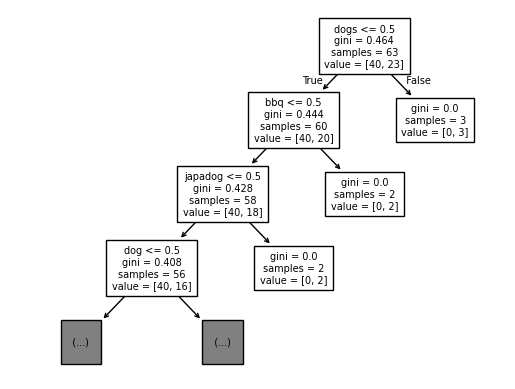

In [35]:
plot_tree(
    tree["decisiontreeclassifier"],
    feature_names=vocab,
    max_depth=3,
    fontsize=7
)
plt.show()

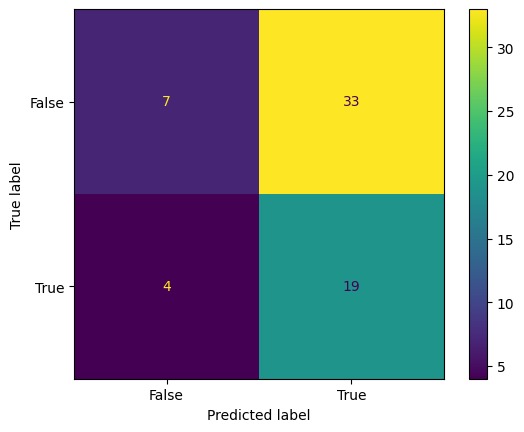

In [36]:
display_confusion_matrix(tree)

In [37]:
display_model_mistmatches(tree)

,y,y_hat,x,probabilities
39,False,True,Marimba,"[0.0, 1.0]"
14,False,True,Mogu,"[0.0, 1.0]"
35,False,True,Commissary Connect,"[0.0, 1.0]"
3,False,True,Aussie Pie Guy,"[0.0, 1.0]"
69,False,True,Lemon Sea,"[0.0, 1.0]"
78,False,True,San Juan Family Farm,"[0.0, 1.0]"
61,False,True,Suassy Thai,"[0.0, 1.0]"
4,False,True,Le Tigre,"[0.0, 1.0]"
18,False,True,Vie Niapolotan,"[0.0, 1.0]"
48,False,True,Come Arepa,"[0.0, 1.0]"


In [38]:
# logistic regression

lr = build_pipeline(LogisticRegression(random_state=522))

record_and_display_cv_scores("Logistic Regression", lr)

,fit_time,score_time,test_score,train_score
0,0.004795,0.001189,0.615385,0.780000
1,0.003926,0.000953,0.615385,0.820000
2,0.002429,0.000724,0.615385,0.840000
3,0.002321,0.000740,0.833333,0.784314
4,0.002669,0.000821,0.750000,0.823529


In [39]:
# fit model and look at the classes for the model

lr.fit(X_train, y_train)

lr.classes_

array([False,  True])

In [40]:
lr_coefficients = pd.DataFrame({
    "token": vocab,
    "coefficient": lr["logisticregression"].coef_[0]
})

lr_coefficients

,token,coefficient
0,actual,-0.288868
1,ali,0.252019
2,arancino,-0.274974
3,arepa,-0.288868
4,arturo,-0.206981
...,...,...
90,tube,0.450637
91,van,0.190846
92,vie,-0.288868
93,wraps,-0.347684


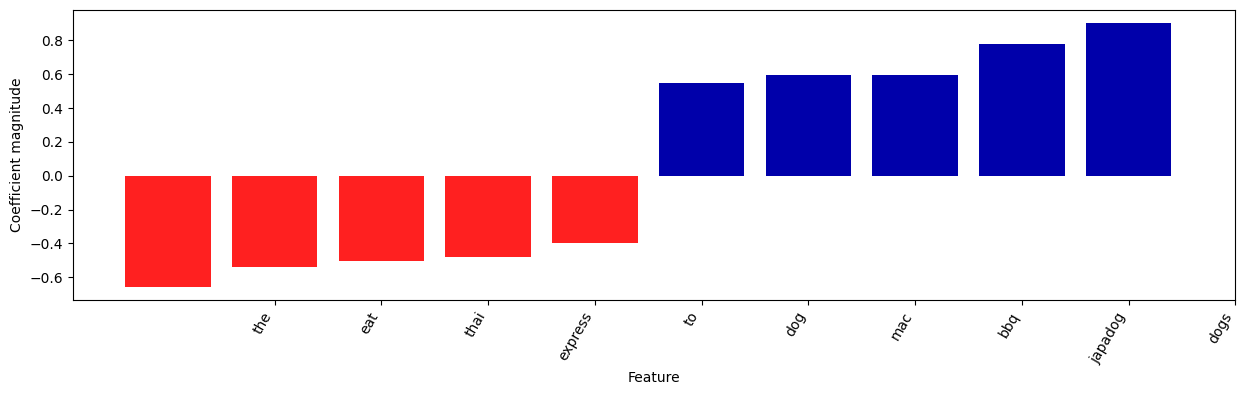

In [41]:
visualize_coefficients(
    lr_coefficients['coefficient'].to_numpy(),
    vocab,
    n_top_features=5
)

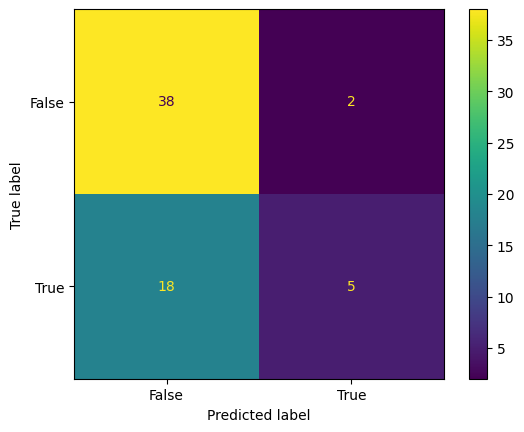

In [42]:
# confusion matrix for test predictions

ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(
        lr,
        X_train,
        y_train
    )
)

In [43]:
display_model_mistmatches(lr)

,y,y_hat,x,probabilities
64,False,True,Van Dog,"[0.2667999752011667, 0.7332000247988333]"
69,False,True,Lemon Sea,"[0.46275075909225794, 0.5372492409077421]"
16,True,False,Sea Dogs,"[0.5044715315798389, 0.495528468420161]"
63,True,False,Van Dog,"[0.5408657706168261, 0.4591342293831739]"
44,True,False,,"[0.5559202270628498, 0.44407977293715023]"
83,True,False,Dog Meister,"[0.5610386009395438, 0.4389613990604562]"
8,True,False,,"[0.5767844402459679, 0.4232155597540322]"
1,True,False,,"[0.5767844402459679, 0.4232155597540322]"
32,True,False,,"[0.5767844402459679, 0.4232155597540322]"
65,True,False,,"[0.5810117083158131, 0.418988291684187]"


In [44]:
# classification/regression analysis 2

naive_bayes = build_pipeline(BernoulliNB())

record_and_display_cv_scores("Naïve-Bayes", naive_bayes)

,fit_time,score_time,test_score,train_score
0,0.002028,0.000813,0.692308,0.780000
1,0.001555,0.000777,0.615385,0.820000
2,0.001569,0.000783,0.692308,0.840000
3,0.001825,0.000942,0.833333,0.784314
4,0.001577,0.000865,0.750000,0.823529


In [45]:
naive_bayes.fit(X_train, y_train)

naive_bayes.classes_

array([False,  True])

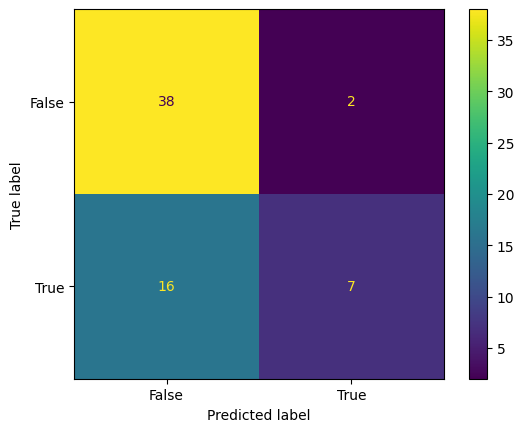

In [46]:
# confusion matrix for test predictions

ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(
        naive_bayes,
        X_train,
        y_train
    )
)

In [47]:
display_model_mistmatches(naive_bayes)

,y,y_hat,x,probabilities
64,False,True,Van Dog,"[0.044828809023268835, 0.9551711909767308]"
69,False,True,Lemon Sea,"[0.29784367729882794, 0.702156322701172]"
83,True,False,Dog Meister,"[0.56089848046478, 0.43910151953521964]"
44,True,False,,"[0.5957116734789062, 0.40428832652109337]"
8,True,False,,"[0.6711991921260541, 0.32880080787394605]"
1,True,False,,"[0.6711991921260541, 0.32880080787394605]"
32,True,False,,"[0.6711991921260541, 0.32880080787394605]"
37,True,False,Holy Smokes,"[0.692765469630229, 0.3072345303697712]"
68,True,False,,"[0.692765469630229, 0.3072345303697712]"
80,True,False,,"[0.692765469630229, 0.3072345303697712]"


In [13]:
# DELETE

naive_bayes.fit(X_train, y_train)

naive_bayes.score(X_test, y_test)

0.7857142857142857

In [21]:
# DELETE
# to look at the probability score for examples with wrong predictions

data_dict = {
    "y": y_train,
    "y_hat": lr.predict(X_train).tolist(),
    "x": X_train.tolist(),
    "probabilities": lr.predict_proba(X_train).tolist(),
}

df = pd.DataFrame(data_dict)

df_mismatch = df[df["y"] != df["y_hat"]]
df_mismatch

,y,y_hat,x,probabilities
65,True,False,,"[0.5801395239309264, 0.4198604760690736]"
80,True,False,,"[0.5801395239309264, 0.4198604760690736]"
68,True,False,,"[0.5801395239309264, 0.4198604760690736]"
64,False,True,Van Dog,"[0.3971416784253534, 0.6028583215746466]"
2,True,False,,"[0.5801395239309264, 0.4198604760690736]"
31,True,False,,"[0.5801395239309264, 0.4198604760690736]"
79,True,False,,"[0.5801395239309264, 0.4198604760690736]"
33,True,False,,"[0.5801395239309264, 0.4198604760690736]"
44,True,False,,"[0.5801395239309264, 0.4198604760690736]"
8,True,False,,"[0.5801395239309264, 0.4198604760690736]"


In [17]:
lr.score(X_test, y_test)

0.7857142857142857

In [18]:
# visualization of the result of the analysis


# Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

Ideas
- Talk about the probability predictions for the logistric regression, the confidence of the model prediction
- Talk about the confusion matrix
    - it would be ideal if the each class would represent roughly 50–50% of the samples
    - our data is somewhat imbalanced, it is not severe so we didn't make adjustments
- Discuss the overall result using the two models
- What other ways can we optimize the current model
    - hyperparameter tuning
    - using `class_weight` to balance dataset
- What other models can we consider in the future
...

# References

at least 4 citations relevant to the project (format is your choose, just be consistent across the references).

# Note:
- Make sure to render to PDF form and push to GitHub.
- Everyone should contribute equally to the code and writing!
- Git commit messages should be meaningful; they will be marked!
- Use GitHub issues to assign tasks and communicate!
- Proper grammar and full sentences in README